#Correlation-Based Neighbourhood Model implementation

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from scipy.stats import pearsonr

def number_user(R_i, R_j):
    """ Calculate number of users that rated both movie i and movie j.

    Parameters:
        R_i (1-D np.array): Variable i (i-th movie).
        R_j (1-D np.array): Variable j (j-th movie).

    Returns:
        n_ij (float): Number of users that rated both movie i and movie j.

    """

    n_ij = 0
    for a, b in zip(R_i, R_j):
        if a and b :  # Increment n_ij if both ratings are not equal to zero
            n_ij += 1
            
    return n_ij

In [0]:
def similarity_matrix(R, lambda_2=100):
    """ Calculate the similarity

    Parameters: 
    R (csr_matrix): Ratings matrix.
    lamdba_1 (float): Regulation coefficient. 
  
    Returns: 
    S (array): Similarity matrix

    """

    R = R.tocsr()
    n = R.shape[1]
    S = np.zeros((n, n))
    for i in range(n):
        R_i = R[:, i].toarray()  # i-th variable's data
        v_i = [v[0] for v in R_i]  # We're using lists since we can't  multiply a sequence by a float 
        for j in range(i+1):
            R_j = R[:, j].toarray()  # j-th variable's data
            v_y = [v[0] for v in R_j] 
            
            # Calculate number of users that rated both i and j
            n_ij = number_user(R_i, R_j)

            # Calculate S_ij using the giving formula
            S[i, j], _ = (n_ij / (n_ij + lambda_2))*np.asarray(pearsonr(v_i, v_y))
    S += S.T
    
    return S

In [0]:
def k_similar_movies(R, S, u, i, k):
    """ Calculate the first k similar movies rated by user u.

    Parameters: 
    R (csr_matrix): Ratings matrix.
    S (2-D np.array): Similarity matrix.
    u (int): User's index.
    i (int): Movie's index.
    k (int): Number of movie's neighbours to consider.

    Returns: 
    R_iu_k (1-D np.array): Set of k nearest movies for which 
                           ratings by u are available.

    """

    S_ui = {}  # Dictionnary: Movie_index -> similarity with movie i if r_ui > 0

    for j in range(len(S)):
        S_ui[j] = S[i, j]  # Add movie and it's similarity to i        

    # Remove i if it's one of the selected movies
    if i in S_ui:
        del S_ui[i]
    
    # Sort by similarity and keep the first k indices
    S_iu_k = [v[0] for v in 
             sorted(S_ui.items(), key=lambda x: x[1], reverse=True)[:k]]

    return S_iu_k

In [0]:
def gradient_J(R, S, k, B_i, B_u, mu, lamdba_2):
    """Calculate stochastic gradient descent for the Baseline model.

    Parameters:
        R (coo_matrix): Rating matrix.
        S (2-D np.array): Similarity matrix.
        k (int): Number of movie's neighbours to consider.
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.
        lambda_2 (float): Penality coefficient.

    Returns:
        b_i (1-D np.array): Gradient of observed deviation for each movie.
        b_u (1-D np.array): Gradient of observed deviation for each user.

    """

    users, items = R.nonzero()
    b_u, b_i =  np.zeros(len(B_u)), np.zeros(len(B_i))
    for u, i in zip(users, items):
        S_ui_k = k_similar_movies(R, S, u, i, k)
        
        r = B_i[i] + B_u[u] + mu + \
            sum([S[i, j]*(R[u, j] - B_u[u] - B_i[j] - mu) for j in S_ui_k])/ \
                sum([S[i, j] for j in S_ui_k])

        e = R[u, i] - r
        b_u[u] += e - lamdba_2*B_u[u]
        b_i[i] += e - lamdba_2*B_i[i]

    return -2*b_i, -2*b_u

In [0]:
def rmse(R, S, k, B_i, B_u, mu):
    """Calculate the root-mean-square deviation using the
       estimated parameters.

    Parameters:
        R (coo_matrix): Rating matrix.
        S (2-D np.array): Similarity matrix.
        k (int): Number of movie's neighbours to consider.
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.

    Returns:
        error (float): RMSE error value.

    """

    users, items = R.nonzero()
    error = 0
    for u, i in zip(users, items):
        S_ui_k = k_similar_movies(R, S, u, i, k)
        r = B_i[i] + B_u[u] + mu + \
            sum([S[i, j]*(R[u, j] - B_u[u] - B_i[j] - mu) for j in S_ui_k])/ \
            sum([S[i, j] for j in S_ui_k])
        error += pow(R[u, i] - r, 2)
    error = (1 / R.shape[0]) * error
    
    return error

In [0]:
def recreate_matrix(R, S, k, B_i, B_u, mu):
    """Recreate the matrix using estimated parameters.

    Parameters:
        R (coo_matrix): Rating matrix.
        S (2-D np.array): Similarity matrix.
        k (int): Number of movie's neighbours to consider.
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.

    Returns:
        R_estimated (2-D np.array): Recreated rating matrix.

    """
    R = R.tocsr()
    R_estimated = np.zeros((len(B_u), len(B_i)))

    for u in range(len(B_u)):
        for i in range(len(B_i)):
            S_ui_k = k_similar_movies(R, S, u, i, k)
            R_estimated[u, i] = B_i[i] + B_u[u] + mu + \
            sum([S[i, j]*(R[u, j] - B_u[u] - B_i[j] - mu) for j in S_ui_k])/ \
                sum([S[i, j] for j in S_ui_k])

    return R_estimated

In [0]:
def recommend_k_movies(R, S, k, B_i, B_u, mu, u, k_m):
    """Recommend k movies to the user u.

    Parameters:
        R (coo_matrix): Rating matrix.
        S (2-D np.array): Similarity matrix.
        k (int): Number of movie's neighbours to consider.
        B_i (1-D np.array): Observed deviation for each movie.
        B_i (1-D np.array): Observed deviation for each user.
        mu (float): Overall average rating.
        u (int): Index of the user.
        k_m (int): Number of movie to recommend.

    Returns:
        R_u_k (list): List of recommended movies' indices.

    """
    
    R = R.tocsr()
    R_u = {}
    for i in range(len(B_i)):
        S_ui_k = k_similar_movies(R, S, u, i, k)

        if R[u, i] == 0:  # If the user u didn't watch the movie i yet
            R_u[i] = B_i[i] + B_u[u] + mu + \
                    sum([S[i, j]*(R[u, j] - B_u[u] - B_i[j] - mu) \
                         for j in S_ui_k])/ sum([S[i, j] for j in S_ui_k])
    
    # Sort movies by estimated rating and keep the first k movies
    R_u_k_m = [v[0] for v in 
             sorted(R_u.items(), key=lambda x: x[1], reverse=True)[:k_m]]
    
    return R_u_k_m

In [0]:
def correlation_based_neighbourhood_model (R, N, k, delta=0.01, lamdba_2=0.02, verbose=False, plot=True):
    """Estimate Correlation based neighbourhood model parameters using SGD.

    Parameters:
        R (coo_matrix): Rating matrix.
        N (int): Number of iterations.
        k (int): Number of movie's neighbours to consider.
        delta (float): Learning rate.
        lambda_1 (float): Penality coefficient.
        plot (boolean): Plot RMSE track if True.
        verbose (boolean): Print number of the current iteration at excecution.

    Returns:
        B_i_opt (1-D array): Optimal observed deviation for each movie.
        B_u_opt (1-D array): Optimal observed deviation for each user.

    """

    # Weight initialization
    B_u = 2.5 * np.random.rand(R.shape[0])
    B_i = 2.5 * np.random.rand(R.shape[1])

    # Logs initialization
    mse_track = np.zeros(N) 
    w_track = []

    # Calculate overall average rating value
    mu = R.data.mean()

    # Calculate similarity matrix
    S = similarity_matrix(R, lambda_2=100)

    # Convert R into a csr_matrix
    R = R.tocsr()

    # SDG on N iterations
    for i in range(0, N):
        if verbose:
            print("Iteration "+ str(i))
        
        # Calculate SGD 
        gradient = gradient_J(R, S, k, B_i, B_u, mu, lamdba_2)
        B_i = B_i - delta * gradient[0] 
        B_u = B_u - delta * gradient[1]

        # Saving RMSE values
        mse_track[i] = rmse(R, S, k, B_i, B_u, mu)

        # Saving estimated parameters
        w_track.append([B_i, B_u])

    # Selecting the optimal parameters
    idx_min = np.argmin(mse_track)
    B_i_opt = w_track[idx_min][0]
    B_u_opt = w_track[idx_min][1]

    # Ploting RMSE deviation if plot is True
    if plot:
        mse_track = np.array([float(round(mse,3)) for mse in mse_track])
        plt.figure(figsize = (20,8))
        plt.rcParams['axes.facecolor'] = 'orange'
        plt.grid(c='white')
        plt.plot(np.arange(0,N), mse_track, 'blue')
        plt.xlabel('Iteration')
        plt.ylabel('MSE')
        plt.title('Minimum MSE = {:.4f} reached at iteration {}'.format(min(mse_track),idx_min+1), fontsize = 15)
        plt.axvline(x = idx_min, color = 'green')

    return B_i_opt, B_u_opt

# Dump example

In [10]:
from scipy.sparse import coo_matrix
R = coo_matrix(np.array([
                [0, 3, 0, 4, 0, 5, 2],
                [1, 0, 0, 2, 1, 2, 0],
                [5, 2, 4, 5, 0, 0, 3],
                [3, 0, 0, 3, 5, 5, 1],
                [1, 0, 5, 0, 1, 1, 0],
                [2, 4, 1, 4, 2, 3, 0],
                [0, 0, 0, 2, 0, 0, 4],
                [1, 4, 4, 3, 3, 0, 2]]
))

# Calculating the Similarity matrice
S = similarity_matrix(R)
S

array([[ 0.11320755,  0.00116995,  0.01229715,  0.02502684,  0.01024774,
        -0.0030502 ,  0.00081666],
       [ 0.00116995,  0.07692308,  0.00540691,  0.02419159,  0.00042778,
         0.00070939,  0.00074511],
       [ 0.01229715,  0.00540691,  0.07692308, -0.00520629, -0.00214576,
        -0.0119774 , -0.00084693],
       [ 0.02502684,  0.02419159, -0.00520629,  0.13084112, -0.00099808,
         0.00827561,  0.01593902],
       [ 0.01024774,  0.00042778, -0.00214576, -0.00099808,  0.0952381 ,
         0.01449574, -0.00731571],
       [-0.0030502 ,  0.00070939, -0.0119774 ,  0.00827561,  0.01449574,
         0.0952381 , -0.00779897],
       [ 0.00081666,  0.00074511, -0.00084693,  0.01593902, -0.00731571,
        -0.00779897,  0.0952381 ]])

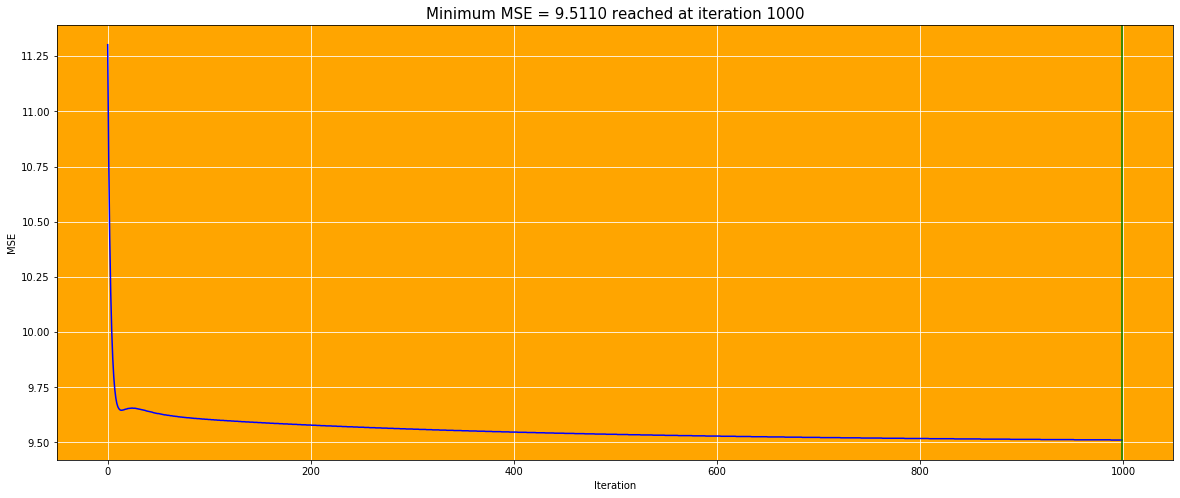

In [11]:
# Estimating Correlation based neighbourhood model parameters using SGD.

B_i_opt, B_u_opt = correlation_based_neighbourhood_model (R, k=4, N=1000, delta=0.01, lamdba_2=0.02, plot=True)

In [12]:
recreate_matrix(R, S, 3, B_i_opt, B_u_opt, mu=R.data.mean())

array([[ 1.26121122,  2.278489  ,  1.21673254,  2.76044737,  2.8824604 ,
         2.13651969,  2.37109408],
       [ 0.42445534,  0.74402   ,  1.08446099,  1.54146204,  1.51094389,
         1.95834662,  0.46851038],
       [ 2.82128575,  3.95777336,  4.4932044 ,  4.55428092,  2.02164768,
         2.45875067,  3.47259849],
       [ 1.81220827,  1.60631524,  2.4932044 ,  2.55428092,  4.05283911,
         4.78017355,  1.47259849],
       [ 0.66476811,  0.05017202,  1.08446099,  1.54146204,  0.9350594 ,
         1.25346177, -1.35300945],
       [ 1.95054161,  2.53026665,  3.09694992,  3.41067598,  2.5619278 ,
         3.40142339,  2.50699826],
       [ 0.20903868,  0.70599571,  0.15400199,  2.13585652, -0.04794596,
         1.3410005 ,  0.42184628],
       [ 2.4153632 ,  2.23318289,  2.26697416,  3.51582428,  0.42715346,
         3.66632709,  1.54957425]])

In [15]:
# Recommend k movies to user u uing the Model.

recommend_k_movies(R, S, 3, B_i_opt, B_u_opt, mu=R.data.mean(), u = 2, k_m = 2)

[5, 4]

In [0]:
R.toarray()

array([[0, 3, 0, 4, 0, 5, 2],
       [1, 0, 0, 2, 1, 2, 0],
       [5, 2, 4, 5, 0, 0, 3],
       [3, 0, 0, 3, 5, 5, 1],
       [1, 0, 5, 0, 1, 1, 0],
       [2, 4, 1, 4, 2, 3, 0],
       [0, 0, 0, 2, 0, 0, 4],
       [1, 4, 4, 3, 3, 0, 2]], dtype=int64)

# Real application

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***L'execution de cette partie prend beaucoup de temps sur Colab !***

In [0]:
from scipy.sparse import save_npz, load_npz, coo_matrix

def load_matrix(M_name):
    """ Load previously saved sparce matrix M.

    Parameters:
        M_name (string): Matrix name as saved in drive (R, T or D).

    Returns:
        M (coo_matrix): Saved matrix.

    """

    M = load_npz("/content/drive/My Drive/Factorisation matricielle - dataset/training_set_csv/"+M_name+".npz")

    return M

In [0]:
# Loading R matrix

R = load_matrix("R")

In [0]:
import datetime
start = datetime.datetime.now()

B_i_opt, B_u_opt = correlation_based_neighbourhood_model (T, k=4, N=500, delta=0.01, lamdba_2=0.02, plot=True)

print("Parameters estimated in : {}".format(datetime.datetime.now() - start))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [0]:
import datetime
start = datetime.datetime.now()

R_estimate = recreate_matrix(B_i_opt, B_u_opt, mu=R.data.mean())

print("Parameters estimated in : {}".format(datetime.datetime.now() - start))